Most of the scientific community deals with the basic problem of trying to mathematically model the reality around them and this often involves dynamical systems. The general trend to model these complex dynamical systems is through the use of differential equations. Differential equation models often have non-measurable parameters. The popular “forward-problem” of simulation consists of solving the differential equations for a given set of parameters, the “inverse problem” to simulation, known as parameter estimation, is the process of utilizing data to determine these model parameters.
Bayesian inference provides a robust approach to parameter estimation with quantified uncertainty.

In [1]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);

## The Lotka-Volterra Model

The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations.
These differential equations are frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey.
The populations change through time according to the pair of equations

$$
\begin{aligned}
\frac{\mathrm{d}x}{\mathrm{d}t} &= (\alpha - \beta y(t))x(t), \\
\frac{\mathrm{d}y}{\mathrm{d}t} &= (\delta x(t) - \gamma)y(t)
\end{aligned}
$$

where $x(t)$ and $y(t)$ denote the populations of prey and predator at time $t$, respectively, and $\alpha, \beta, \gamma, \delta$ are positive parameters.

We implement the Lotka-Volterra model and simulate it with parameters $\alpha = 1.5$, $\beta = 1$, $\gamma = 3$, and $\delta = 1$ and initial conditions $x(0) = y(0) = 1$.

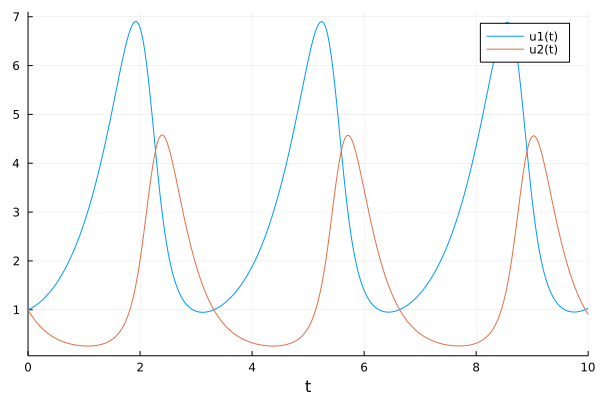

In [2]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ *   - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [1.5, 1.0, 3.0, 1.0]
tspan = (0.0, 10.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p)

# Plot simulation.
plot(solve(prob, Tsit5()))

We generate noisy observations to use for the parameter estimation tasks in this tutorial.
With the [`saveat` argument](https://docs.sciml.ai/latest/basics/common_solver_opts/) we specify that the solution is stored only at `0.1` time units.
To make the example more realistic we add random normally distributed noise to the simulation.

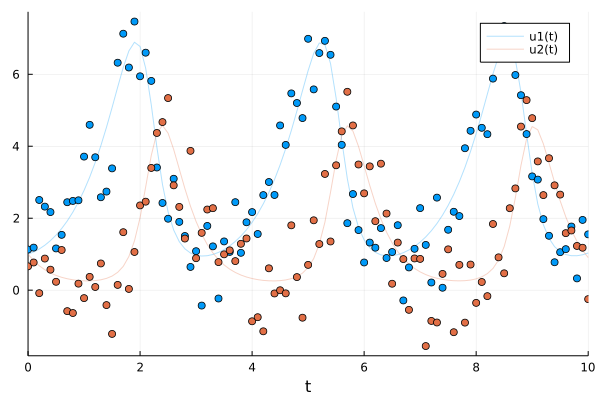

In [3]:
sol = solve(prob, Tsit5(); saveat=0.1)
odedata = Array(sol) + 0.8 * randn(size(Array(sol)))

# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(sol.t, odedata'; color=[1 2], label="")

## Direct Handling of Bayesian Estimation with Turing

Previously, functions in Turing and DifferentialEquations were not inter-composable, so Bayesian inference of differential equations needed to be handled by another package called [DiffEqBayes.jl](https://github.com/SciML/DiffEqBayes.jl) (note that DiffEqBayes works also with CmdStan.jl, Turing.jl, DynamicHMC.jl and ApproxBayes.jl - see the [DiffEqBayes docs](https://docs.sciml.ai/latest/analysis/parameter_estimation/#Bayesian-Methods-1) for more info).

Nowadays, however, Turing and DifferentialEquations are completely composable and we can just simulate differential equations inside a Turing `@model`.
Therefore, we write the Lotka-Volterra parameter estimation problem using the Turing `@model` macro as below:

In [4]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end
 
    return nothing
end

model = fitlv(odedata, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(0.65), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/Advanced

Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 48.35 seconds
Compute duration  = 46.65 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           σ    1.1944    0.5939     0.0108    0.0797    6.0793    9.6816      ⋯
           α    1.3879    0.1367     0.0025    0.0164    7.7631    2.1647      ⋯
           β    0.9529    0.0998     0.0018    0.0096   12.1349    1.4525      ⋯
           γ    2.4500    0.9465     0.0173    0.1267    6.1190    7.6917      ⋯
           δ    0.8823    0.2317     0.0042    0.0304    6.

The estimated parameters are close to the parameter values the observations were generated with.
We can also check visually that the chains have converged.

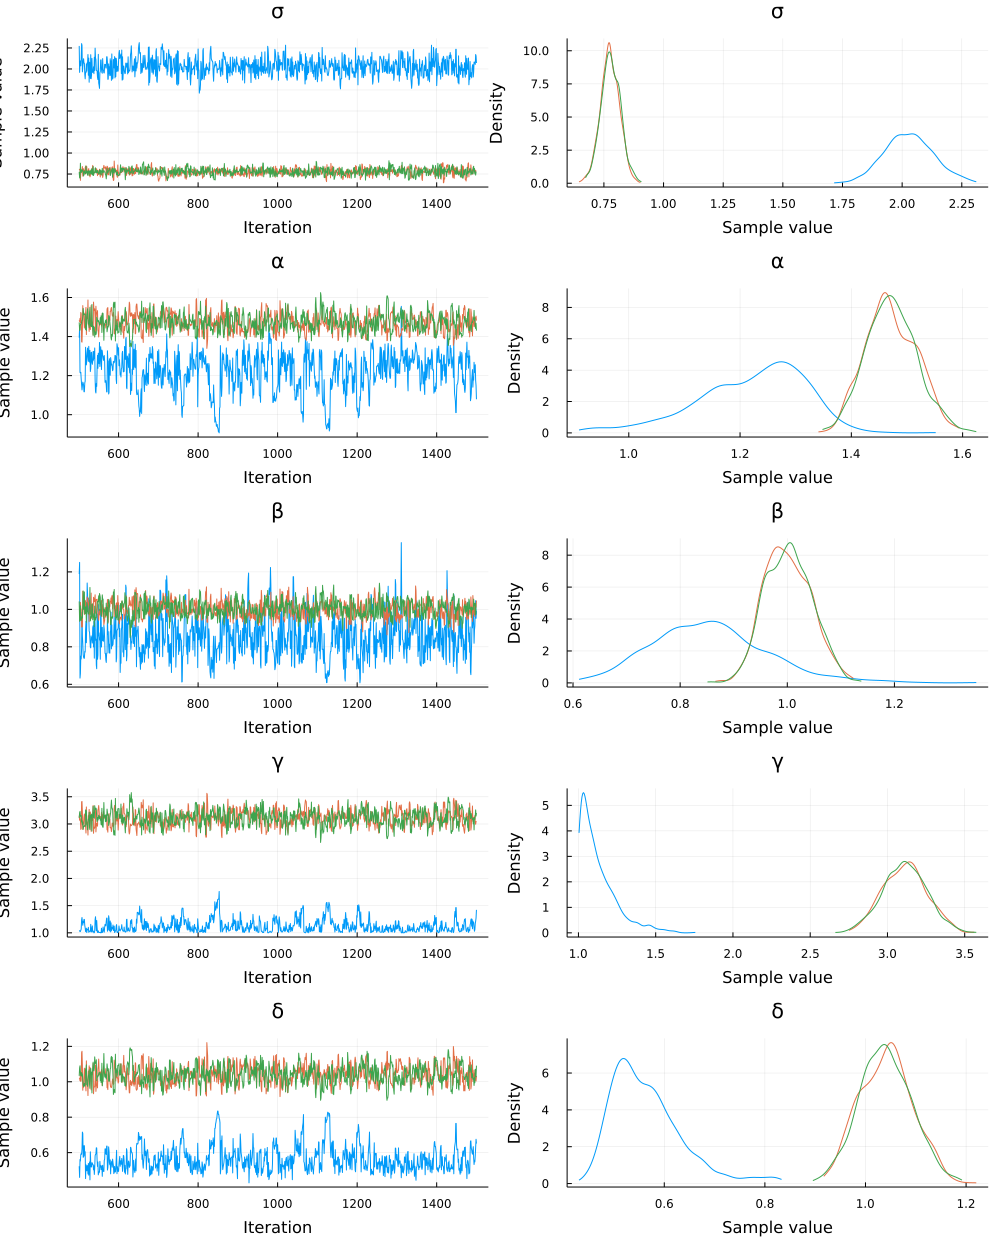

In [5]:
plot(chain)

### Data retrodiction

In Bayesian analysis it is often useful to retrodict the data, i.e. generate simulated data using samples from the posterior distribution, and compare to the original data (see for instance section 3.3.2 - model checking of McElreath's book "Statistical Rethinking").
Here, we solve the ODE for 300 randomly picked posterior samples in the `chain`.
We plot the ensemble of solutions to check if the solution resembles the data.
The 300 retrodicted time courses from the posterior are plotted in gray, the noisy observations are shown as blue and red dots, and the green and purple lines are the ODE solution that was used to generate the data.

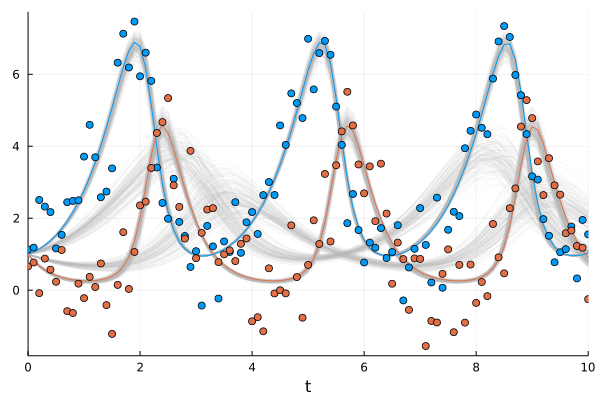

In [6]:
plot(; legend=false)
posterior_samples = sample(chain[[:α, :β, :γ, :δ]], 300; replace=false)
for p in eachrow(Array(posterior_samples))
    sol_p = solve(prob, Tsit5(); p=p, saveat=0.1)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
plot!(sol; color=[1 2], linewidth=1)
scatter!(sol.t, odedata'; color=[1 2])

We can see that, even though we added quite a bit of noise to the data the posterior distribution reproduces quite accurately the "true" ODE solution.

## Lotka-Volterra model without data of prey

One can also perform parameter inference for a Lotka-Volterra model with incomplete data.
For instance, let us suppose we have only observations of the predators but not of the prey.
I.e., we fit the model only to the $y$ variable of the system without providing any data for $x$:

In [7]:
@model function fitlv2(data::AbstractVector, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)

    # Simulate Lotka-Volterra model but save only the second state of the system (predators).
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1, save_idxs=2)

    # Observations of the predators.
    data ~ MvNormal(predicted.u, σ^2 * I)

    return nothing
end

model2 = fitlv2(odedata[2, :], prob)

# Sample 3 independent chains.
chain2 = sample(model2, NUTS(0.45), MCMCSerial(), 5000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/Advanc

Chains MCMC chain (5000×17×3 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 3
Samples per chain = 5000
Wall duration     = 29.48 seconds
Compute duration  = 29.14 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ    0.8130    0.0578     0.0005    0.0037   101.3506    1.0264     ⋯
           α    1.6421    0.1885     0.0015    0.0111   150.3550    1.0060     ⋯
           β    1.1453    0.1456     0.0012    0.0083   157.0674    1.0046     ⋯
           γ    2.9547    0.2750     0.0022    0.0159   157.4518    1.0110     ⋯
           δ    0.8343    0.2183     0.0018    0.0128   14

Again we inspect the trajectories of 300 randomly selected posterior samples.

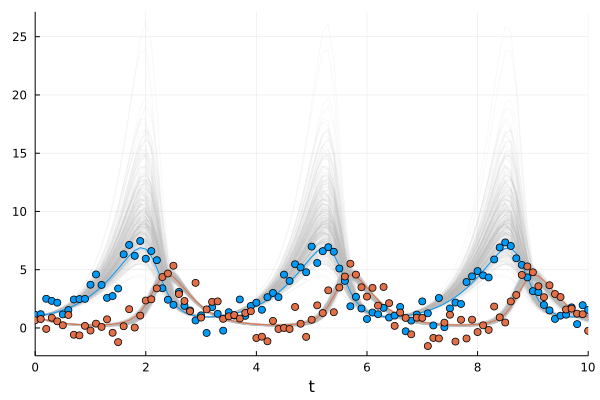

In [8]:
plot(; legend=false)
posterior_samples = sample(chain2[[:α, :β, :γ, :δ]], 300; replace=false)
for p in eachrow(Array(posterior_samples))
    sol_p = solve(prob, Tsit5(); p=p, saveat=0.1)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
plot!(sol; color=[1 2], linewidth=1)
scatter!(sol.t, odedata'; color=[1 2])

Note that here the observations of the prey (blue dots) were not used in the parameter estimation!
Yet, the model can predict the values of $x$ relatively accurately, albeit with a wider distribution of solutions, reflecting the greater uncertainty in the prediction of the $x$ values.

## Inference of Delay Differential Equations

Here we show an example of inference with another type of differential equation: a Delay Differential Equation (DDE).
DDEs are differential equations where derivatives are function of values at an earlier point in time.
This is useful to model a delayed effect, like incubation time of a virus for instance.

Here is a delayed version of the Lokta-Voltera system:

$$
\begin{aligned}
\frac{\mathrm{d}x}{\mathrm{d}t} &= \alpha x(t-\tau) - \beta y(t) x(t),\\
\frac{\mathrm{d}y}{\mathrm{d}t} &= - \gamma y(t) + \delta x(t) y(t),
\end{aligned}
$$

where $\tau$ is a (positive) delay and $x(t-\tau)$ is the variable $x$ at an earlier time point $t - \tau$.

The initial-value problem of the delayed system can be implemented as a [`DDEProblem`](https://diffeq.sciml.ai/stable/tutorials/dde_example/).
As described in the [DDE example](https://diffeq.sciml.ai/stable/tutorials/dde_example/), here the function `h` is the history function that can be used to obtain a state at an earlier time point.
Again we use parameters $\alpha = 1.5$, $\beta = 1$, $\gamma = 3$, and $\delta = 1$ and initial conditions $x(0) = y(0) = 1$.
Moreover, we assume $x(t) = 1$ for $t < 0$.

In [9]:
function delay_lotka_volterra(du, u, h, p, t)
    # Model parameters.
    α, β, γ, δ = p

    # Current state.
    x, y = u
    # Evaluate differential equations
    du[1] = α * h(p, t - 1; idxs=1) - β * x * y
    du[2] = -γ * y + δ * x * y

    return nothing
end

# Define initial-value problem.
p = (1.5, 1.0, 3.0, 1.0)
u0 = [1.0; 1.0]
tspan = (0.0, 10.0)
h(p, t; idxs::Int) = 1.0
prob_dde = DDEProblem(delay_lotka_volterra, u0, h, tspan, p);

We generate observations by adding normally distributed noise to the results of our simulations.

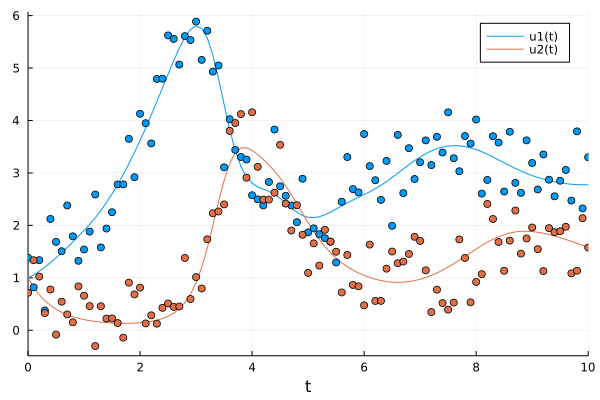

In [10]:
sol_dde = solve(prob_dde; saveat=0.1)
ddedata = Array(sol_dde) + 0.5 * randn(size(sol_dde))

# Plot simulation and noisy observations.
plot(sol_dde)
scatter!(sol_dde.t, ddedata'; color=[1 2], label="")

Now we define the Turing model for the Lotka-Volterra model with delay and sample 3 independent chains.

In [11]:
@model function fitlv_dde(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ Truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ Truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ Truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ Truncated(Normal(1.0, 0.5), 0, 2)

    # Simulate Lotka-Volterra model.
    p = [α, β, γ, δ]
    predicted = solve(prob, MethodOfSteps(Tsit5()); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end
end

model_dde = fitlv_dde(ddedata, prob_dde)

# Sample 3 independent chains.
chain_dde = sample(model_dde, NUTS(0.65), MCMCSerial(), 300, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ Ad

Chains MCMC chain (300×17×3 Array{Float64, 3}):

Iterations        = 151:1:450
Number of chains  = 3
Samples per chain = 300
Wall duration     = 19.47 seconds
Compute duration  = 19.15 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ    0.4730    0.0242     0.0008    0.0010   530.4840    1.0004     ⋯
           α    1.5683    0.0717     0.0024    0.0039   250.1124    1.0086     ⋯
           β    1.0841    0.0556     0.0019    0.0027   339.7972    1.0036     ⋯
           γ    2.9875    0.1565     0.0052    0.0091   260.3488    1.0103     ⋯
           δ    0.9906    0.0537     0.0018    0.0031   248.99

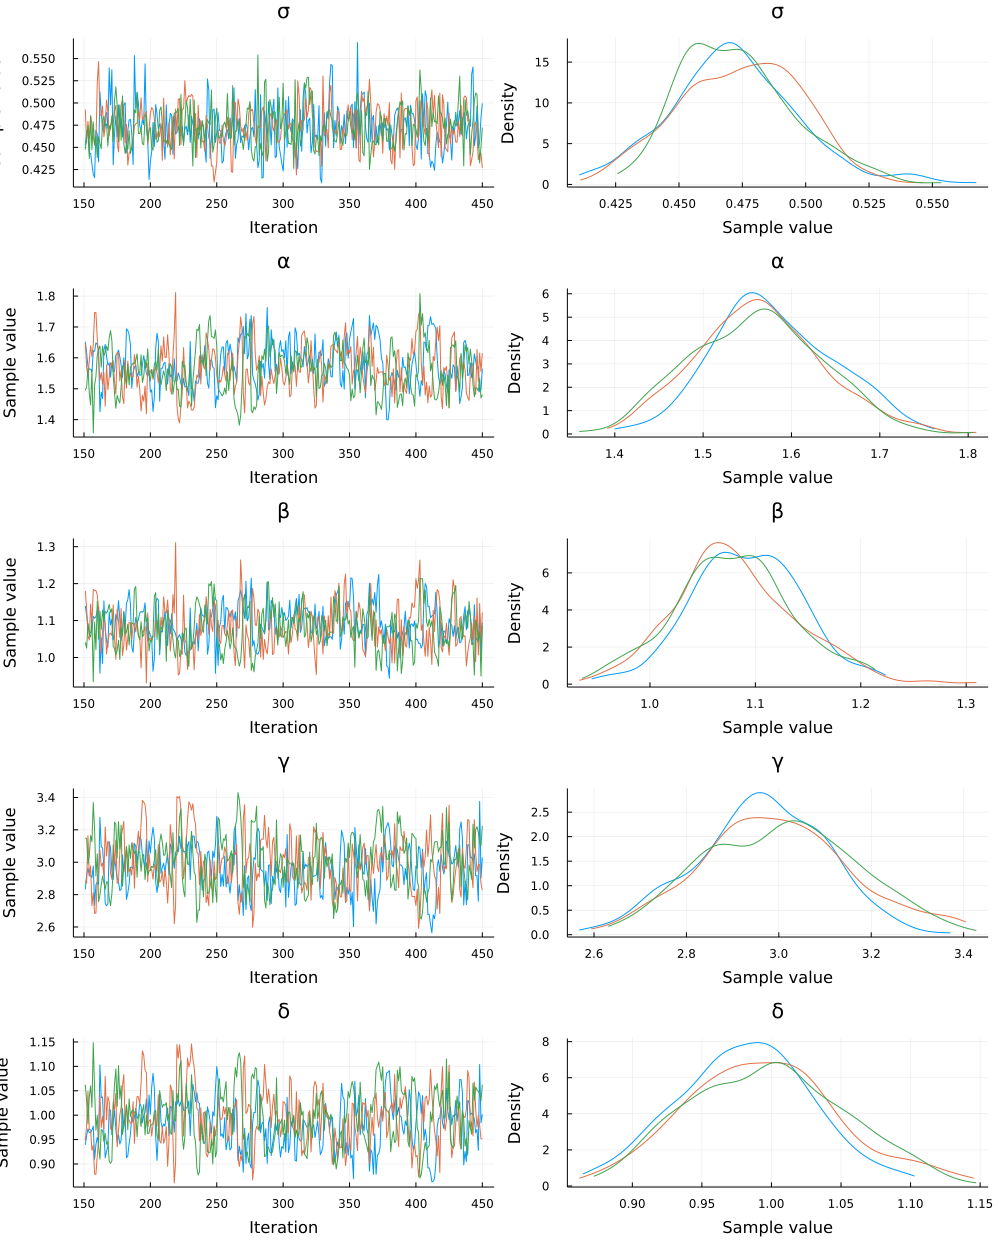

In [12]:
plot(chain_dde)

Finally, plot trajectories of 300 randomly selected samples from the posterior.
Again, the dots indicate our observations, the colored lines are the "true" simulations without noise, and the gray lines are trajectories from the posterior samples.

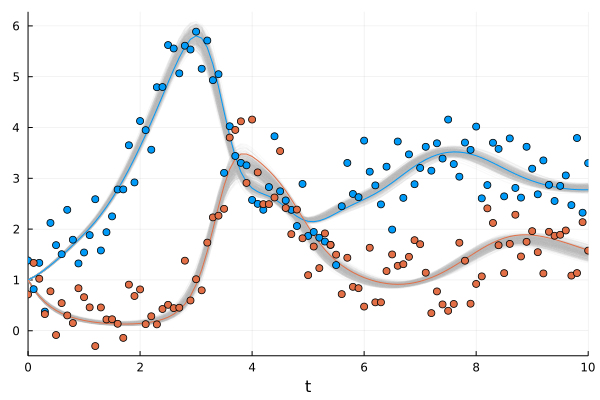

In [13]:
plot(; legend=false)
posterior_samples = sample(chain_dde[[:α, :β, :γ, :δ]], 300; replace=false)
for p in eachrow(Array(posterior_samples))
    sol_p = solve(prob_dde, MethodOfSteps(Tsit5()); p=p, saveat=0.1)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
plot!(sol_dde; color=[1 2], linewidth=1)
scatter!(sol_dde.t, ddedata'; color=[1 2])

The fit is pretty good even though the data was quite noisy to start.

## Scaling to Large Models: Adjoint Sensitivities

DifferentialEquations.jl's efficiency for large stiff models has been shown in multiple [benchmarks](https://github.com/SciML/DiffEqBenchmarks.jl).
To learn more about how to optimize solving performance for stiff problems you can take a look at the [docs](https://docs.sciml.ai/latest/tutorials/advanced_ode_example/).

[Sensitivity analysis](https://docs.sciml.ai/latest/analysis/sensitivity/), or automatic differentiation (AD) of the solver, is provided by the DiffEq suite.
The model sensitivities are the derivatives of the solution with respect to the parameters.
Specifically, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter.
Sensitivity analysis provides a cheap way to calculate the gradient of the solution which can be used in parameter estimation and other optimization tasks.

The AD ecosystem in Julia allows you to switch between forward mode, reverse mode, source to source and other choices of AD and have it work with any Julia code.
For a user to make use of this within [SciML](https://sciml.ai), [high level interactions in `solve`](https://docs.sciml.ai/latest/analysis/sensitivity/#High-Level-Interface:-sensealg-1) automatically plug into those AD systems to allow for choosing advanced sensitivity analysis (derivative calculation) [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1).

More theoretical details on these methods can be found at: https://docs.sciml.ai/latest/extras/sensitivity_math/.

While these sensitivity analysis methods may seem complicated, using them is dead simple.
Here is a version of the Lotka-Volterra model using adjoint sensitivities.

All we have to do is switch the AD backend to one of the adjoint-compatible backends (ReverseDiff, Tracker, or Zygote)!
Notice that on this model adjoints are slower.
This is because adjoints have a higher overhead on small parameter models and therefore we suggest using these methods only for models with around 100 parameters or more.
For more details, see https://arxiv.org/abs/1812.01892.

In [14]:
using Zygote, DiffEqSensitivity

# Sample a single chain with 1000 samples using Zygote.
setadbackend(:zygote)
sample(model, NUTS(0.65), 1000; progress=false)

LoadError: ArgumentError: Package Zygote not found in current path:
- Run `import Pkg; Pkg.add("Zygote")` to install the Zygote package.


If desired, we can control the sensitivity analysis method that is used by providing the `sensealg` keyword argument to `solve`.
For instance, we can choose the [`InterpolatingAdjoint` method](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1) with a compiled ReverseDiff vector-Jacobian product:

In [15]:
@model function fitlv_sensealg(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)

    # Simulate Lotka-Volterra model and use a specific algorithm for computing sensitivities.
    p = [α, β, γ, δ]
    predicted = solve(
        prob;
        p=p,
        saveat=0.1,
        sensealg=InterpolatingAdjoint(; autojacvec=ReverseDiffVJP(true)),
    )

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end;

model_sensealg = fitlv_sensealg(odedata, prob)

# Sample a single chain with 1000 samples using Zygote.
setadbackend(:zygote)
sample(model_sensealg, NUTS(0.65), 1000; progress=false)

LoadError: MethodError: no method matching setadbackend(::Val{:zygote})
[0mClosest candidates are:
[0m  setadbackend([91m::Symbol[39m) at ~/.julia/packages/AdvancedVI/W2zsz/src/ad.jl:5
[0m  setadbackend([91m::Val{:forward_diff}[39m) at ~/.julia/packages/AdvancedVI/W2zsz/src/ad.jl:6
[0m  setadbackend([91m::Val{:forwarddiff}[39m) at ~/.julia/packages/AdvancedVI/W2zsz/src/ad.jl:10
[0m  ...

For more examples of adjoint usage on large parameter models, consult the [DiffEqFlux documentation](https://diffeqflux.sciml.ai/dev/).

## Inference of a Stochastic Differential Equation

A [Stochastic Differential Equation (SDE)](https://diffeq.sciml.ai/stable/tutorials/sde_example/) is a differential equation that has a stochastic (noise) term in the expression of the derivatives.
Here we fit a stochastic version of the Lokta-Volterra system.

We use a quasi-likelihood approach in which all trajectories of a solution are compared instead of a reduction such as mean, this increases the robustness of fitting and makes the likelihood more identifiable.
We use SOSRI to solve the equation.

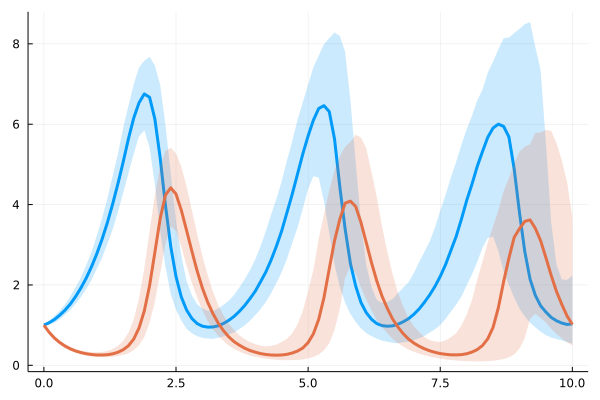

In [16]:
u0 = [1.0, 1.0]
tspan = (0.0, 10.0)
function multiplicative_noise!(du, u, p, t)
    x, y = u
    du[1] = p[5] * x
    return du[2] = p[6] * y
end
p = [1.5, 1.0, 3.0, 1.0, 0.1, 0.1]

function lotka_volterra!(du, u, p, t)
    x, y = u
    α, β, γ, δ = p
    du[1] = dx = α * x - β * x * y
    return du[2] = dy = δ * x * y - γ * y
end

prob_sde = SDEProblem(lotka_volterra!, multiplicative_noise!, u0, tspan, p)

ensembleprob = EnsembleProblem(prob_sde)
data = solve(ensembleprob, SOSRI(); saveat=0.1, trajectories=1000)
plot(EnsembleSummary(data))

In [17]:
@model function fitlv_sde(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.3, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.25), 0.5, 2)
    γ ~ truncated(Normal(3.2, 0.25), 2.2, 4.0)
    δ ~ truncated(Normal(1.2, 0.25), 0.5, 2.0)
    ϕ1 ~ truncated(Normal(0.12, 0.3), 0.05, 0.25)
    ϕ2 ~ truncated(Normal(0.12, 0.3), 0.05, 0.25)

    # Simulate stochastic Lotka-Volterra model.
    p = [α, β, γ, δ, ϕ1, ϕ2]
    predicted = solve(prob, SOSRI(); p=p, saveat=0.1)

    # Early exit if simulation could not be computed successfully.
    if predicted.retcode !== :Success
        Turing.@addlogprob! -Inf
        return nothing
    end

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end;

The probabilistic nature of the SDE solution makes the likelihood function noisy which poses a challenge for NUTS since the gradient is changing with every calculation.
Therefore we use NUTS with a low target acceptance rate of `0.25` and specify a set of initial parameters.
SGHMC might be a more suitable algorithm to be used here.

┌ Info: Found initial step size
│   ϵ = 0.01660481097792401
└ @ Turing.Inference /Users/svollmer/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/svollmer/.julia/pa

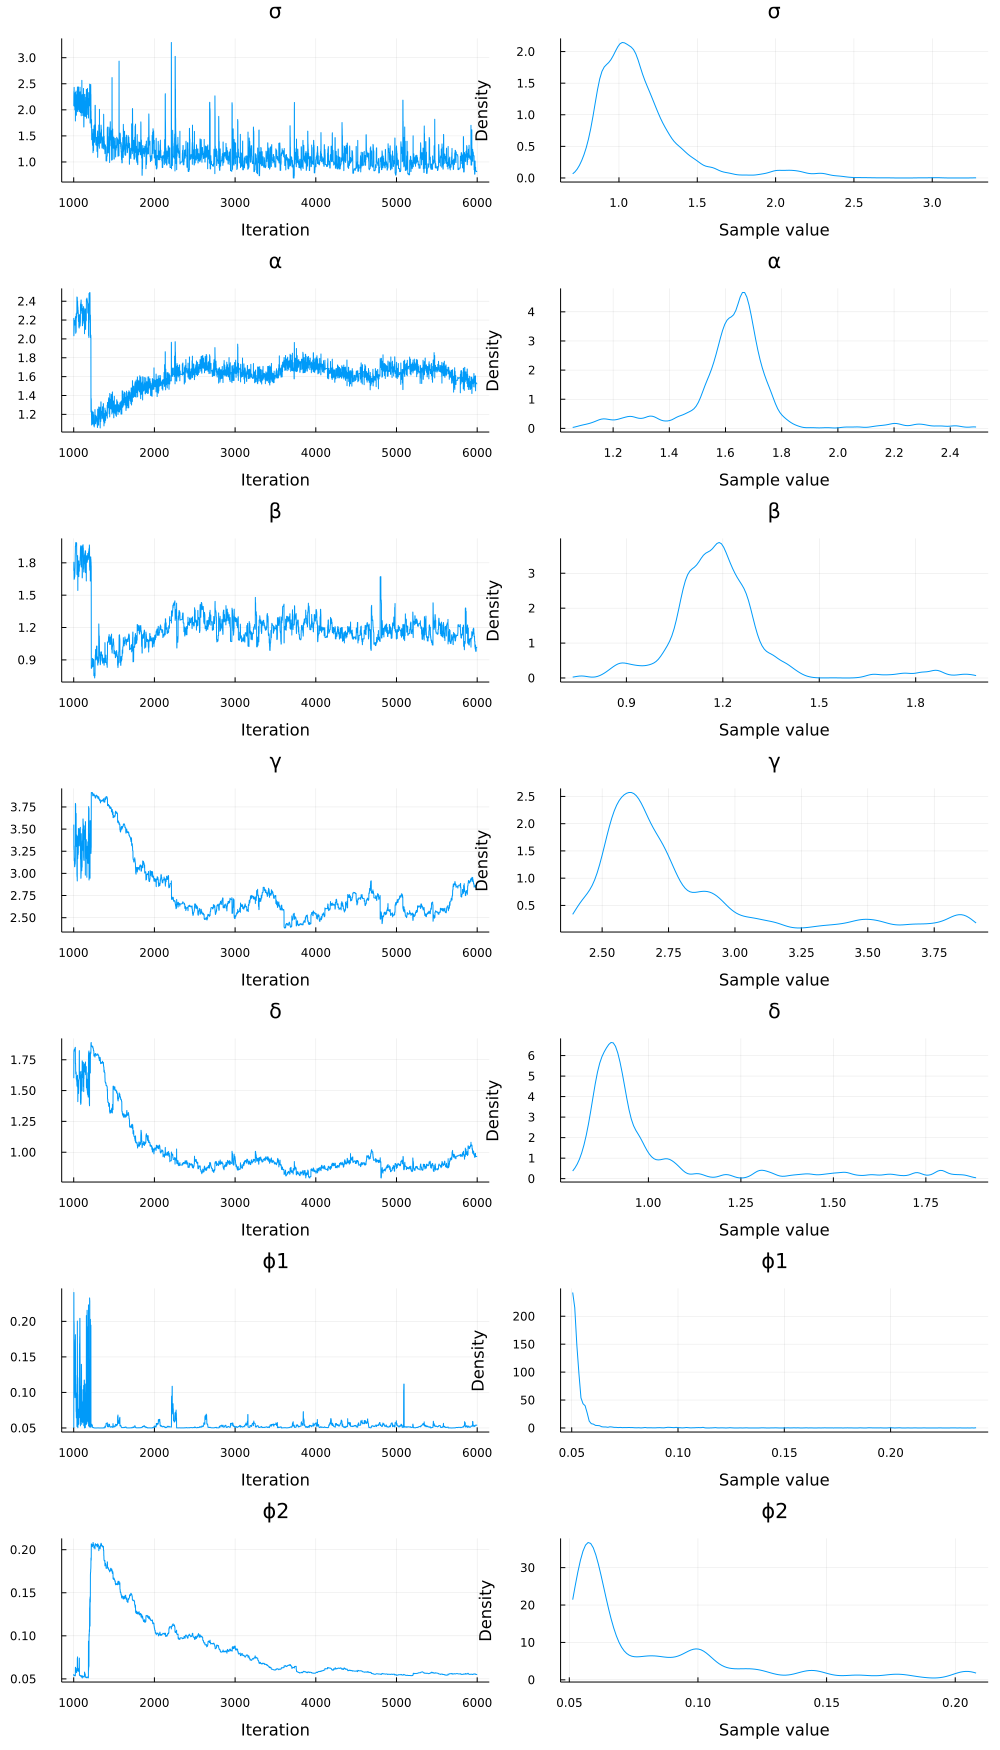

In [18]:
model_sde = fitlv_sde(odedata, prob_sde)

setadbackend(:forwarddiff)
chain_sde = sample(
    model_sde,
    NUTS(0.25),
    5000;
    init_params=[1.5, 1.3, 1.2, 2.7, 1.2, 0.12, 0.12],
    progress=false,
)
plot(chain_sde)

In [19]:
if isdefined(Main, :TuringTutorials)
    Main.TuringTutorials.tutorial_footer(WEAVE_ARGS[:folder], WEAVE_ARGS[:file])
end